In [1]:
from pathlib import Path
from ase import io
import pandas as pd
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core import Structure, Lattice
from pymatgen.analysis.structure_matcher import StructureMatcher
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

In [2]:
def get_paths(model):
    pc_mapping = {
        'TD': 'new-timesteps',
        'pos-only': 'baseline'
    }
        
    initial_path = Path(
        f'/Users/treents/Documents/Work/PhD/PSI/Mattergen crystal structure inpainting/50-steps/n-samples-per-structure/{model}-5-samples/{model}-5-samples_initial_structures/generated_crystals.extxyz'
        )

    generated_path = Path(
        f'/Users/treents/Documents/Work/PhD/PSI/Mattergen crystal structure inpainting/50-steps/n-samples-per-structure/{model}-5-samples/{model}-5-samples_N_structures--1__N_steps-50__coordinates_snr-0.2__n_corrector_steps-1__batch_size-500__N_samples_per_structure-5__{pc_mapping[model]}/generated_crystals.extxyz'
    )
    relaxed_path = Path(
        f'/Users/treents/Documents/Work/PhD/PSI/Mattergen crystal structure inpainting/50-steps/n-samples-per-structure/{model}-5-samples/{model}-5-samples_N_structures--1__N_steps-50__coordinates_snr-0.2__n_corrector_steps-1__batch_size-500__N_samples_per_structure-5__{pc_mapping[model]}/structures_relaxed/generated_crystals.extxyz'
        )
    df_path = Path(
        f'/Users/treents/Documents/Work/PhD/PSI/Mattergen crystal structure inpainting/50-steps/n-samples-per-structure/{model}-5-samples/{model}-5-samples_N_structures--1__N_steps-50__coordinates_snr-0.2__n_corrector_steps-1__batch_size-500__N_samples_per_structure-5__{pc_mapping[model]}/{model}-5-samples_N_structures--1__N_steps-50__coordinates_snr-0.2__n_corrector_steps-1__batch_size-500__N_samples_per_structure-5__{pc_mapping[model]}_df_results.csv'
    )

    return initial_path, generated_path, relaxed_path, df_path

In [7]:
def get_rmsds(initial_atoms, generated_atoms, strct_idx):
    sm = StructureMatcher(primitive_cell=False)
    non_matching = 0
    rmsds = []
    matched = {}

    for i, gen_structure in enumerate(generated_atoms):
        ref_structure = initial_atoms[strct_idx[i]]
        
        ref_structure = AseAtomsAdaptor.get_structure(ref_structure)
        gen_structure = AseAtomsAdaptor.get_structure(gen_structure)
        
        if not sm.fit(ref_structure, gen_structure):
            non_matching += 1
            continue
        
        gen_structure = sm.get_s2_like_s1(ref_structure, gen_structure)
        if gen_structure is None:
            # print(f"Structure {i} does not match the reference structure.")
            non_matching += 1
            continue
        
        matched[strct_idx[i]] = matched.get(strct_idx[i], 0) + 1
        
        # extract hydrogen sites from both structures
        gen_H_sites = [site.frac_coords for site in gen_structure if site.specie.symbol == 'H']
        ref_H_sites = [site.frac_coords for site in ref_structure if site.specie.symbol == 'H']

        if len(gen_H_sites) != len(ref_H_sites):
            print(f"Mismatch in hydrogen count: generated={len(gen_H_sites)}, reference={len(ref_H_sites)}")
        else:
            # build a cost matrix of distances between hydrogen sites
            dist_matrix = ref_structure.lattice.get_all_distances(
                gen_H_sites,
                ref_H_sites,
            )

            # solve the assignment problem to match hydrogen sites
            row_ind, col_ind = linear_sum_assignment(dist_matrix)
            matched_distances = dist_matrix[row_ind, col_ind]
            # avg_distance = np.mean(matched_distances)
            rmsd = np.linalg.norm(matched_distances) / len(ref_H_sites) ** 0.5
            rmsds.append(rmsd)
            if rmsd > 1:
                print(rmsd, sm.fit(ref_structure, gen_structure))
                print(gen_structure, ref_structure)
            # print(f"Average hydrogen distance: {avg_distance:.3f}")
            # print(f"RMSD of hydrogen sites: {rmsd:.3f}")
            
    print(f"Total number of structures: {len(generated_atoms)}")
    print(f"Number of non-matching structures: {non_matching}")
    
    return rmsds, matched

In [8]:
results = {}

for model in ['TD', 'pos-only']:
    initial_path, generated_path, relaxed_path, df_path = get_paths(model)
    initial_atoms = io.read(initial_path, index=':')
    generated_atoms = io.read(generated_path, index=':')
    relaxed_atoms = io.read(relaxed_path, index=':')
    
    df = pd.read_csv(
        df_path
    )
    ref_keys = df['ref_key'].to_list()
    strct_idx = df['ref_key'].apply(lambda x: int(x.split('-')[0])).to_list()
    
    rmsds, matched = get_rmsds(initial_atoms, generated_atoms, strct_idx)
    rmsds_relaxed, matched_relaxed = get_rmsds(initial_atoms, relaxed_atoms, strct_idx)
    
    results.update({
        f'{model} unrelaxed': rmsds,
    })
    results.update({
        f'{model} relaxed': rmsds_relaxed,
    })

Total number of structures: 3870
Number of non-matching structures: 678
Total number of structures: 3870
Number of non-matching structures: 632
Total number of structures: 3870
Number of non-matching structures: 1184
Total number of structures: 3870
Number of non-matching structures: 982


In [9]:
results_df = pd.DataFrame({key: pd.Series(val) for key, val in results.items()})

In [18]:
results_df.quantile(np.arange(0, 1.05, 0.05))

,TD unrelaxed,TD relaxed,pos-only unrelaxed,pos-only relaxed
0.00,0.000657,0.000101,0.000952,0.000050
0.05,0.003620,0.001005,0.007777,0.001077
0.10,0.004926,0.001491,0.010562,0.001488
0.15,0.006314,0.002063,0.012928,0.001964
0.20,0.007659,0.002531,0.015189,0.002493
0.25,0.009429,0.003024,0.017556,0.003029
0.30,0.011131,0.003596,0.020007,0.003840
0.35,0.013214,0.004295,0.022606,0.004669
0.40,0.015124,0.004986,0.025274,0.005681
0.45,0.017717,0.005949,0.028565,0.006748


In [14]:
results_df.max()

TD unrelaxed          0.655540
TD relaxed            0.701445
pos-only unrelaxed    0.691767
pos-only relaxed      0.704715
dtype: float64

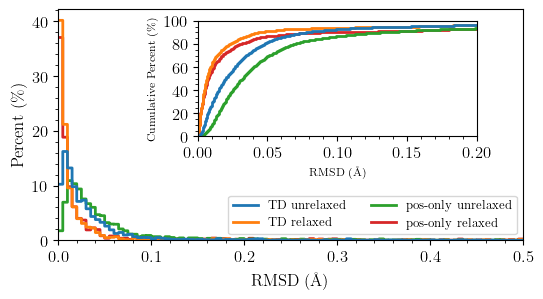

In [30]:
fig, ax = plt.subplots(nrows=1, figsize=(6, 3))

plt.subplots_adjust(hspace=0.3)

ax = [ax]
sns.histplot(
    data=results_df.melt(
        var_name='model',
        value_name='rmsd',
        value_vars=['TD unrelaxed', 'TD relaxed', 'pos-only unrelaxed', 'pos-only relaxed']
    ),
    x='rmsd',
    hue='model',
    bins=np.arange(0, 3, 0.005),
    fill=False,
    stat='percent',
    common_norm=False,
    element='step',
    linewidth=2,
    ax=ax[0],
)
ax[0].set_xlim(0, 0.5)
ax[0].set_xlabel('RMSD (Å)')
ax[0].set_ylabel('Percent (\%)')
sns.move_legend(ax[0], loc='lower right', ncol=2, title=None)

# Create an inset axis in the upper right of ax[0]
inset_ax = ax[0].inset_axes([0.3, 0.45, 0.6, 0.5])
sns.histplot(
    data=results_df.melt(
        var_name='model',
        value_name='rmsd',
        value_vars=['TD unrelaxed', 'TD relaxed', 'pos-only unrelaxed', 'pos-only relaxed']
    ),
    x='rmsd',
    hue='model',
    bins=np.arange(0, 3, 0.0005),
    fill=False,
    stat='percent',
    common_norm=False,
    element='step',
    linewidth=2,
    ax=inset_ax,
    cumulative=True,
    legend=False,
)
inset_ax.set_yticks(np.arange(0, 121, 20))
inset_ax.set_xlim(0, 0.2)
inset_ax.set_ylim(0, 100)
inset_ax.set_xlabel('RMSD (Å)', fontsize=8)
inset_ax.set_ylabel('Cumulative Percent (\%)', fontsize=8)

plt.savefig(
    'generated_structures_rmsd.pdf', bbox_inches='tight'
    )


<Axes: ylabel='Percent'>

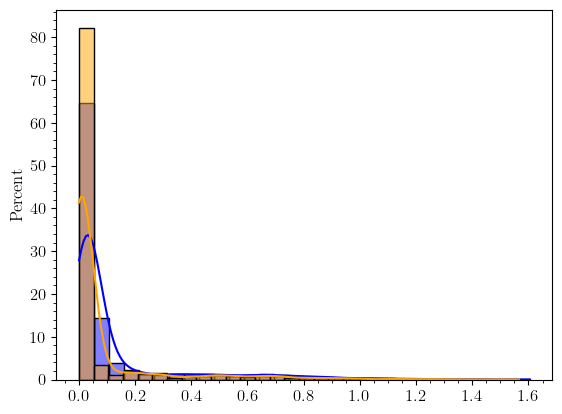

In [290]:
sns.histplot(
    data=rmsds,
    bins=30,
    kde=True,
    stat='percent',
    color='blue',
)
sns.histplot(
    data=rmsds_relaxed,
    bins=30,
    kde=True,
    stat='percent',
    color='orange',
)